In [33]:
# Olympic Medalists 2008 - Tidy Data Project
# Cleaning, transforming, and analyzing the dataset
# By Jada Bautista

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import IsolationForest

file_path = "olympics_08_medalists.csv"
df = pd.read_csv(file_path)

df.head()

,medalist_name,male_archery,female_archery,male_athletics,female_athletics,male_badminton,female_badminton,male_baseball,male_basketball,female_basketball,...,female_beach volleyball,male_volleyball,female_volleyball,male_water polo,female_water polo,male_weightlifting,female_weightlifting,male_freestyle wrestling,female_freestyle wrestling,male_greco-roman wrestling
0,Aaron Armstrong,NaN,NaN,gold,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Aaron Peirsol,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Abdullo Tangriev,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Abeer Abdelrahman,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,bronze,NaN,NaN,NaN
4,Abhinav,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Dealing with Missing data

In [7]:
# Check for missing values
print(df.isnull().sum())

# Delete the rows where all sport columns are NaN
df_cleaned = df.dropna(how="all", subset=df.columns[1:])

# Fill missing medalist names
df_cleaned["medalist_name"].fillna("Unknown", inplace=True)

medalist_name                    0
male_archery                  1864
female_archery                1866
male_athletics                1790
female_athletics              1794
                              ... 
male_weightlifting            1851
female_weightlifting          1854
male_freestyle wrestling      1847
female_freestyle wrestling    1859
male_greco-roman wrestling    1848
Length: 71, dtype: int64


<ipython-input-7-5fb15b349bea>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned["medalist_name"].fillna("Unknown", inplace=True)


## 2. Reshaping data

In [9]:
# Convert the format (wide to long)
df_long = df_cleaned.melt(id_vars=["medalist_name"], var_name="event", value_name="medal")

# Delete the rows where "medal" OR "medalist_name" is NaN
df_long.dropna(subset=["medal", "medalist_name"], inplace=True)

df_long.head()

,medalist_name,event,medal
177,Bair Badënov,male_archery,bronze
676,Ilario Di Buò,male_archery,silver
682,Im Dong-hyun,male_archery,gold
760,Jiang Lin,male_archery,bronze
920,Lee Chang-hwan,male_archery,gold


## 3. Splitting event columns

In [10]:
# Divide the "event" column into "gender" and "sport"
df_long[['gender', 'sport']] = df_long['event'].str.extract(r'^(male|female)?_?(.*)$')

df_long.head()

,medalist_name,event,medal,gender,sport
177,Bair Badënov,male_archery,bronze,male,archery
676,Ilario Di Buò,male_archery,silver,male,archery
682,Im Dong-hyun,male_archery,gold,male,archery
760,Jiang Lin,male_archery,bronze,male,archery
920,Lee Chang-hwan,male_archery,gold,male,archery


## 4. Clean sport names

In [13]:
# Add spaces and apply a titlecase to the sport names
df_long["sport"] = df_long["sport"].str.replace("_", " ").str.title()

df_long.head()

,medalist_name,event,medal,gender,sport
177,Bair Badënov,male_archery,bronze,male,Archery
676,Ilario Di Buò,male_archery,silver,male,Archery
682,Im Dong-hyun,male_archery,gold,male,Archery
760,Jiang Lin,male_archery,bronze,male,Archery
920,Lee Chang-hwan,male_archery,gold,male,Archery


## Handling rare sports

In [17]:
# Determine the sports that have less than 3 occurrences
sport_counts = df_long["sport"].value_counts()
rare_sports = sport_counts[sport_counts < 3].index

# Categorize these rare sports as "Other"
df_long.loc[df_long["sport"].isin(rare_sports), "sport"] = "Other"

df_long["sport"].unique()

array(['Archery', 'Athletics', 'Badminton', 'Baseball', 'Basketball',
       'Boxing', 'Canoeing And Kayaking', 'Road Bicycle Racing',
       'Track Cycling', 'Mountain Biking', 'Bmx', 'Diving',
       'Equestrian Sport', 'Fencing', 'Field Hockey',
       'Association Football', 'Artistic Gymnastics',
       'Rhythmic Gymnastics', 'Trampoline Gymnastics', 'Handball', 'Judo',
       'Modern Pentathlon', 'Rowing', 'Sailing', 'Shooting Sport',
       'Softball', 'Swimming', 'Synchronized Swimming', 'Table Tennis',
       'Taekwondo', 'Tennis', 'Triathlon', 'Beach Volleyball',
       'Volleyball', 'Water Polo', 'Weightlifting', 'Freestyle Wrestling',
       'Greco-Roman Wrestling'], dtype=object)

## Encode categorical features

In [23]:
# Use Label Encoding to convert into numerical format
label_encoder = LabelEncoder()
df_long["gender_encoded"] = label_encoder.fit_transform(df_long["gender"])
df_long["medal_encoded"] = label_encoder.fit_transform(df_long["medal"])

# One-hot encoding for sports
one_hot_encoder = OneHotEncoder(drop="first", handle_unknown="ignore")
sport_encoded = one_hot_encoder.fit_transform(df_long[["sport"]])
sport_encoded_df = pd.DataFrame(sport_encoded.toarray(), columns=one_hot_encoder.get_feature_names_out(["sport"]))

# Avoid column conflicts through merging one-hot encoding sports
df_long = df_long.join(sport_encoded_df, rsuffix="_encoded")

df_long.sample(10)


,medalist_name,event,medal,gender,sport,gender_encoded,medal_encoded,sport_Artistic Gymnastics,sport_Association Football,sport_Athletics,...,sport_Synchronized Swimming_encoded,sport_Table Tennis_encoded,sport_Taekwondo_encoded,sport_Tennis_encoded,sport_Track Cycling_encoded,sport_Trampoline Gymnastics_encoded,sport_Triathlon_encoded,sport_Volleyball_encoded,sport_Water Polo_encoded,sport_Weightlifting_encoded
44693,Steve Guerdat,male_equestrian sport,bronze,male,Equestrian Sport,1,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88593,Emi Inui,female_softball,gold,female,Softball,0,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
124693,Leydi Solís,female_weightlifting,silver,female,Weightlifting,0,2,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14554,Román González,male_basketball,bronze,male,Basketball,1,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66614,Luc Abalo,male_handball,gold,male,Handball,1,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11704,Elier Sánchez,male_baseball,silver,male,Baseball,1,2,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51929,Pan Fengzhen,female_field hockey,silver,female,Field Hockey,0,2,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72001,Jeong Gyeong-mi,female_judo,bronze,female,Judo,0,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92144,Caroline Burckle,female_swimming,bronze,female,Swimming,0,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54880,Fabiana Simões,female_association football,silver,female,Association Football,0,2,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Finalizing the Tidy Dataset

In [25]:
# Keep only the relevant columns
df_tidy = df_long[['medalist_name', 'gender', 'sport', 'medal']]

# Delete exact duplicate rows
df_tidy = df_tidy.drop_duplicates()

# Display cleaned dataset
df_tidy.sample(50)

,medalist_name,gender,sport,medal
81298,Iker Martínez de Lizarduy,male,Sailing,silver
99430,Alexandros Nikolaidis,male,Taekwondo,silver
122917,Marcin Dołęga,male,Weightlifting,bronze
11990,Jayson Nix,male,Baseball,bronze
77293,Dominic Seiterle,male,Rowing,gold
71317,Alina Dumitru,female,Judo,gold
115870,Semyon Poltavskiy,male,Volleyball,bronze
54453,Amy Rodriguez,female,Association Football,gold
98446,Li Jiawei,female,Table Tennis,silver
59637,Shawn Johnson East,female,Artistic Gymnastics,silver


## Visualization

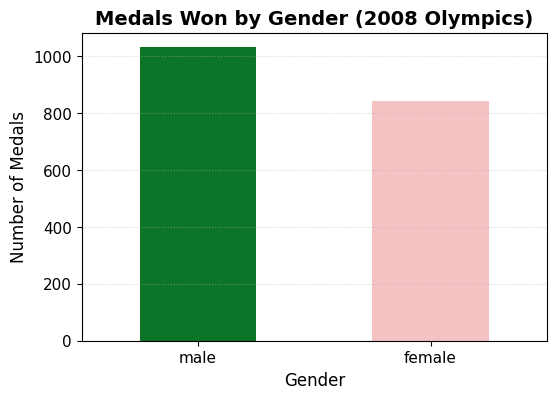

In [26]:
# Count the medals by gender
gender_counts = df_tidy['gender'].value_counts()

# Customize the colors! (Green = Male, Pink = Female)
colors = ['#0b7527', '#F4C2C2']

# Customize the bar chart
plt.figure(figsize=(6, 4))
bar_container = gender_counts.plot(kind='bar', color=colors, edgecolor="black", linewidth=1.5)

for bar in bar_container.containers:
    for rect in bar:
        rect.set_linewidth(0)

plt.title("Medals Won by Gender (2008 Olympics)", fontsize=14, fontweight='bold')
plt.xlabel("Gender", fontsize=12)
plt.ylabel("Number of Medals", fontsize=12)
plt.xticks(rotation=0, fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='y', linestyle='dotted', alpha=0.5)

plt.show()


<Figure size 1200x600 with 0 Axes>

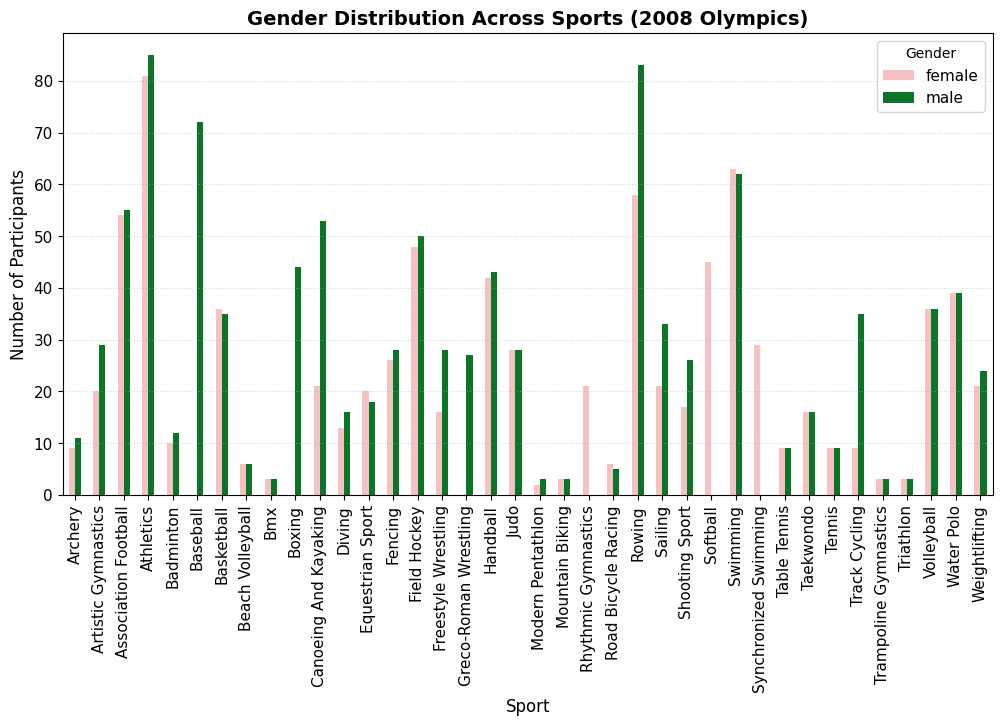

In [28]:
# Count the female and male participation per sport
gender_sport = df_tidy.groupby(["sport", "gender"]).size().unstack()

# Customize the colors! (Green = Male, Pink = Female)
colors = ['#F4C2C2', '#0b7527']

# Customize the chart
plt.figure(figsize=(12, 6))
bar_container = gender_sport.plot(kind="bar", figsize=(12, 6), color=colors, edgecolor="black", linewidth=1.5)

for bar in bar_container.containers:
    for rect in bar:
        rect.set_linewidth(0)

plt.title("Gender Distribution Across Sports (2008 Olympics)", fontsize=14, fontweight='bold')
plt.xlabel("Sport", fontsize=12)
plt.ylabel("Number of Participants", fontsize=12)
plt.xticks(rotation=90, fontsize=11)
plt.yticks(fontsize=11)
plt.legend(title="Gender", fontsize=11)
plt.grid(axis='y', linestyle='dotted', alpha=0.5)

plt.show()

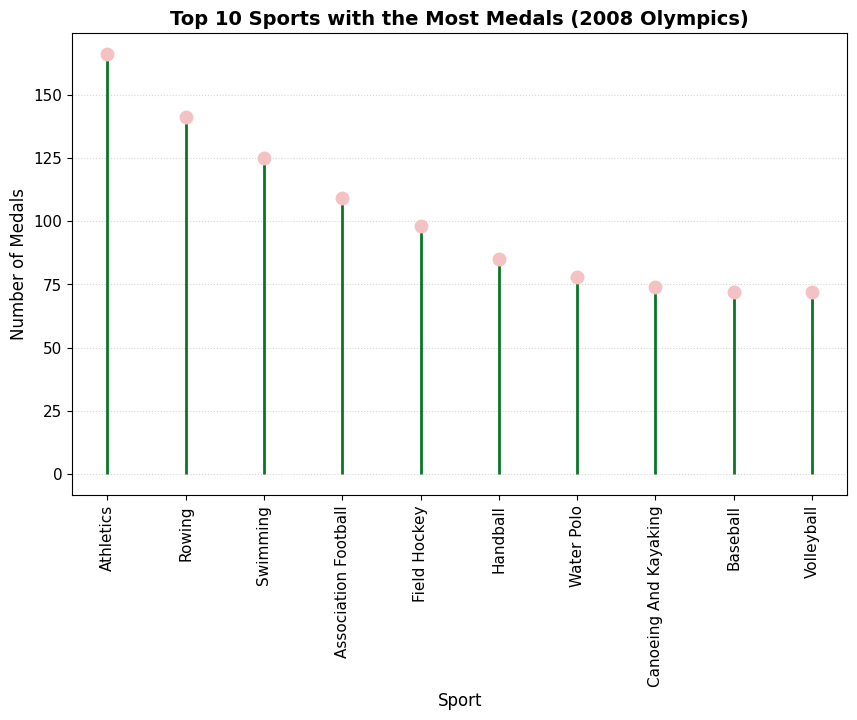

In [29]:
import numpy as np

# Count the top 10 medals per sport
top_sports = df_tidy['sport'].value_counts().head(10)

# Customize the colors!
stem_color = '#0b7527'
marker_color = '#F4C2C2'  # Light Pink for markers

# Customize the chart
plt.figure(figsize=(10, 6))
markerline, stemline, baseline = plt.stem(top_sports.index, top_sports.values,
                                          linefmt=stem_color, markerfmt='o', basefmt=" ")

plt.setp(markerline, markersize=10, markerfacecolor=marker_color, markeredgewidth=0)
plt.setp(stemline, linewidth=2)  # Make stems thicker
plt.setp(baseline, linewidth=0)  # Hide the baseline
plt.title("Top 10 Sports with the Most Medals (2008 Olympics)", fontsize=14, fontweight='bold')
plt.xlabel("Sport", fontsize=12)
plt.ylabel("Number of Medals", fontsize=12)
plt.xticks(rotation=90, fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='y', linestyle='dotted', alpha=0.5)

plt.show()


## Pivot table

In [32]:
# Summarize medals by sport and gender
medal_pivot = df_tidy.pivot_table(index="sport", columns="gender", values="medal", aggfunc="count", fill_value=0)

medal_pivot.sample(10)


gender,female,male
sport,,
Synchronized Swimming,29,0
Taekwondo,16,16
Modern Pentathlon,2,3
Tennis,9,9
Rowing,58,83
Softball,45,0
Diving,13,16
Athletics,81,85
Water Polo,39,39
